# <center>Алгоритм Adaboost</center>

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data_adaboost.csv', header=None)

**Задание.** Реализуйте алгоритм Adaboost.

В качестве базового алгоритма возьмем `DecisionTreeClassifier` глубины 1. Количество базовых алгоритмов $T=3$.

- В переменной `self.sample_weight` будем хранить текущие значения весов объектов.
- В методе `fit` последовательно будет производиться построение пней решения. На первом шаге алгоритма веса всех объектов одинаковы, т.е.:
$$w_i^0=\frac{1}{l}, i=1,\ldots,l,$$
где $l$ &ndash; количество объектов обучающей выборки.
- На каждом шаге алгоритма необходимо обучить пень решения с текущими весами объектов. Веса объектов задаются в методе `fit(X, y, sample_weight=...)` пня.
- После того, как пень обучен, вычислить:
$$\epsilon_t=\sum_{i=1}^{l} w_i[y_i \neq b_t(x_i)],$$
$$\alpha_t=\frac{1}{2}\log\frac{1-\epsilon_t}{\epsilon_t}.$$
- И обновить веса объектов:
$$w_i^t=w_i^{t-1}\exp(-\alpha_t y_i b_t(x_i)), i=1,\ldots,l,$$
$$w_i^t=\frac{w_i^t}{\sum_{j=1}^{l} w_j^t}.$$

- Обученные пни будем хранить в переменной `self.trees`.

In [3]:
from sklearn.base import BaseEstimator

class AdaboostClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=3, max_depth=1, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.sample_weight = []
        
    def fit(self, X, y):
        l = X.shape[0]
        self.sample_weight = np.ones(l) / l
        for t in range(self.n_estimators):
            dt = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            dt.fit(X, y, sample_weight=self.sample_weight)
            dt_predict = dt.predict(X)
            eps = np.dot(self.sample_weight, (dt_predict != y.values))
            alpha = 1 / 2 * np.log((1 - eps) / eps)
            self.sample_weight *= np.exp(-alpha * y.values * dt_predict)
            sum_ = np.sum(self.sample_weight)
            self.sample_weight /= sum_
            self.trees.append(dt)
        
    def predict(self, X):
        return np.sign(sum([self.trees[i].predict(X) for i in range(self.n_estimators)]))

Обучите алгоритм Adaboost. Отобразите полученные пни решений на плоскости. Чтобы получить предикат в пне решений можно воспользоваться методом `stump.tree_.threshold[0]` у обученного пня `stump`. Индекс признака, по которому проводилось разбиение, можно определить  с помощью метода `stump.tree_.feature[0]`.

С помощью обученного алгоритма Adaboost классифицируйте точки обучающей выборки, а также точку (4, 4).

In [4]:
X = data[[0, 1]]
y = data[2]

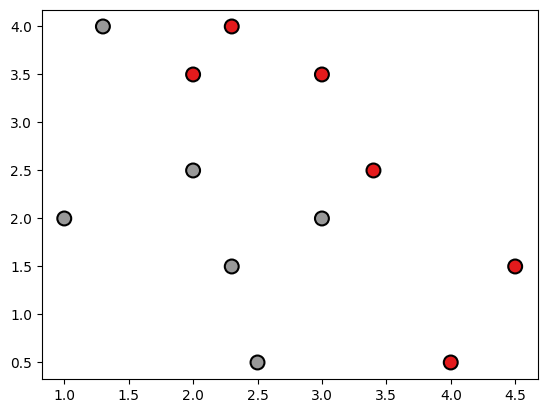

In [5]:
plt.scatter(X[0], X[1], 
            c=y, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.show()

In [6]:
ada = AdaboostClassifierCustom()
ada.fit(X, y)
ada.predict(X)

array([ 1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1])

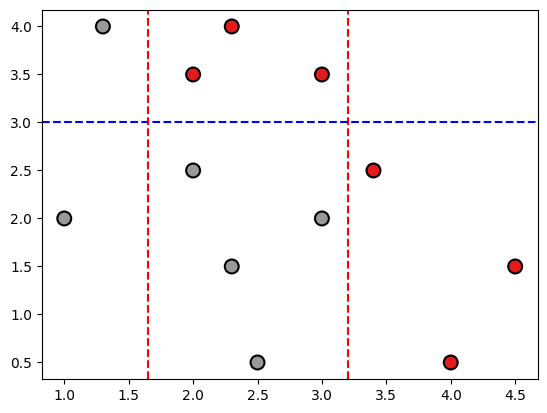

In [7]:
plt.scatter(X[0], X[1], 
            c=ada.predict(X), s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
for tree in ada.trees:
    feature = tree.tree_.feature[0]
    condition = tree.tree_.threshold[0]
    # print(feature, condition)
    if feature == 0:
        plt.axvline(x=condition, color='red', linestyle='--')
    elif feature == 1:
        plt.axhline(y=condition, color='blue', linestyle='--')
plt.show()

In [8]:
new_point = (4, 4)
result = []

for tree in ada.trees:
    feature = tree.tree_.feature[0]
    condition = tree.tree_.threshold[0]
    if new_point[feature] > condition:
        result.append(-1)
    else:
        result.append(1)
        
y_new_point = np.sign(sum(result))

In [9]:
X_data = X.append({0: new_point[0], 1: new_point[1]}, ignore_index=True)
y_data = np.append(ada.predict(X), y_new_point)

/tmp/ipykernel_9535/790835854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_data = X.append({0: new_point[0], 1: new_point[1]}, ignore_index=True)


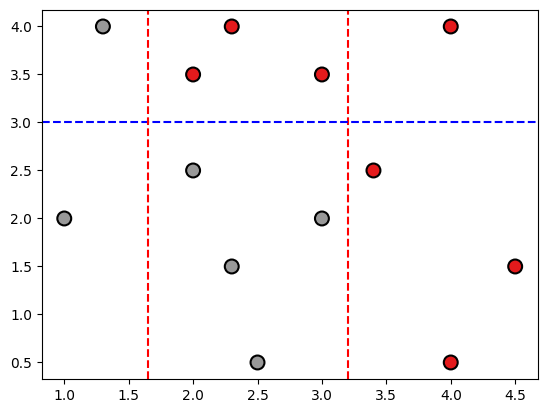

In [10]:
plt.scatter(X_data[0], X_data[1], 
            c=y_data, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
for tree in ada.trees:
    feature = tree.tree_.feature[0]
    condition = tree.tree_.threshold[0]
    # print(feature, condition)
    if feature == 0:
        plt.axvline(x=condition, color='red', linestyle='--')
    elif feature == 1:
        plt.axhline(y=condition, color='blue', linestyle='--')
plt.show()